In [74]:
import os
import torch
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image

In [240]:
Data_dir = '../dataset/chest_xray/chest_xray/train'

In [241]:
stats = (.5, .5, .5), (.5, .5, .5) # 데이터 정규화를 위해 통계치 설정, (평균, 표준편차)

In [242]:
transform_ds = T.Compose([
  T.Resize((100,100)),
  T.RandomHorizontalFlip(),
  T.RandomVerticalFlip(),
  T.ToTensor(),
  T.Normalize(*stats),
  T.Grayscale(num_output_channels=3)
])
ds = torchvision.datasets.ImageFolder(Data_dir, transform=transform_ds)

In [243]:
def denorm(img_tensors): # 역정규화
  return img_tensors * stats[1][0] + stats[0][0]

In [244]:
batch_size = 100

train_loader = DataLoader(ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

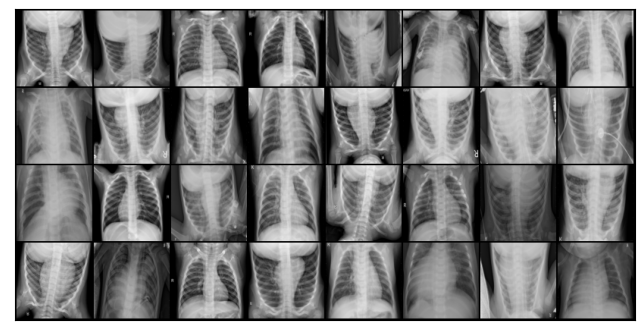

In [245]:
def show_image(train_loader):
  for images, _ in train_loader:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images[:32]), nrow=8).permute(1,2,0))
    break

show_image(train_loader)

In [246]:
# device mps
def get_device():
  return torch.device("mps")

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)
  
device = get_device()
device

device(type='mps')

In [247]:
train_loader = DeviceDataLoader(train_loader, device)

In [300]:
import torch.nn as nn

discriminator = nn.Sequential(
    # 입력: 3 x 100 x 100
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), # 출력: 64 x 50 x 50
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), # 출력: 128 x 25 x 25
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # 출력: 256 x 13 x 13
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), # 출력: 512 x 6 x 6
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    # 추가 레이어: 512 x 6 x 6 -> 512 x 3 x 3
    nn.Conv2d(512, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    # 최종 레이어: 512 x 3 x 3 -> 1 x 1 x 1
    nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)


In [301]:
discriminator = to_device(discriminator, device)

In [303]:
import torch.nn as nn

latent_size = 100  # 잠재 공간의 차원 수

generator = nn.Sequential(
    # 잠재 벡터를 512x4x4 크기로 변환
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    
    # 512x4x4 -> 256x8x8
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    
    # 256x8x8 -> 128x16x16
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    # 128x16x16 -> 64x32x32
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    # 64x32x32 -> 3x100x100
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=3, padding=1, bias=False),
    nn.Tanh()  # 최종 출력 채널을 3으로 설정 (RGB 이미지용)
)


In [304]:
generator = to_device(generator, device)

In [305]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()
    
    real_preds= discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    fake_preds= discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    loss = real_loss + fake_loss
    loss.backward(),
    opt_d.step()
    
    return loss.item(), real_score, fake_score

In [306]:
def train_generator(opt_g):
    opt_g.zero_grad()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    loss.backward(),
    opt_g.step()
    
    return loss.item()

In [307]:
sample_dir = 'generated_images'
os.makedirs(sample_dir, exist_ok=True)

In [308]:
def save_sample(index, fixed_latent, show=True):
    fake_images = generator(fixed_latent)
    fake_fname = "GAN-generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach()[:32], nrow=8).permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


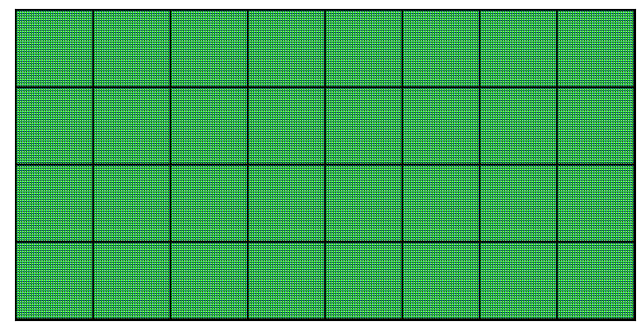

In [309]:
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
save_sample(0, fixed_latent, show=True) 

In [310]:
def fit(epochs, lr_d, lr_g, start_idx=1):
    torch.cuda.empty_cache()
    
    losses_d = []
    losses_g = []
    real_scores = []
    fake_scores = []
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images,_ in tqdm(train_loader):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)
            
        losses_d.append(loss_d)
        losses_g.append(loss_g)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print("Epoch: [{}/{}], loss_d: {:.4f}, loss_g: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_d, loss_g, real_score, fake_score))
        
        save_sample(epoch+start_idx, fixed_latent, show=False)
        
    return losses_d, losses_g, real_scores, fake_scores

In [311]:
epochs = 45
lr_d = 0.001
lr_g = 0.001 

In [312]:
history = fit(epochs, lr_d, lr_g, start_idx=1)

  0%|          | 0/53 [00:00<?, ?it/s]

RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history